<a href="https://colab.research.google.com/github/canerskrc/Borusan_Kod_Adi_Dijital/blob/main/borusan_day17_PCA_advanced_app_car_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"]= (9,6)

100%|██████████| 103k/103k [00:00<00:00, 570kB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/CooperUnion/cardataset/versions/1


In [3]:
df = pd.read_csv("data.csv")
print("orijinal boyut: ", df.shape)
print("sütunlar:", df.columns.tolist())

orijinal boyut:  (11914, 16)
sütunlar: ['Make', 'Model', 'Year', 'Engine Fuel Type', 'Engine HP', 'Engine Cylinders', 'Transmission Type', 'Driven_Wheels', 'Number of Doors', 'Market Category', 'Vehicle Size', 'Vehicle Style', 'highway MPG', 'city mpg', 'Popularity', 'MSRP']


In [4]:
#özellik seçimi

numeric_features = ["Year","Engine HP", "Engine Cylinders","highway MPG","Number of Doors", "city mpg", "MSRP", "Popularity"]
categorical_features = ["Make","Transmission Type","Driven_Wheels","Engine Fuel Type","Market Category","Model"]

#Eksik veri temizleme

for col in numeric_features:
  df[col] = df[col].fillna(df[col].median())

for col in categorical_features:
  df[col] = df[col].fillna("Unknown")

# Veri Ön işleme Pipeline

preprocess = ColumnTransformer(
    transformers= [
        ("num", StandardScaler(), numeric_features),
        ("cat",OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)


In [5]:
#PCA pipeline

pca = PCA(n_components=None, random_state=42)
pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("pca",pca)
])
pipe.fit(df)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Year', 'Engine HP',
                                                   'Engine Cylinders',
                                                   'highway MPG',
                                                   'Number of Doors',
                                                   'city mpg', 'MSRP',
                                                   'Popularity']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Make', 'Transmission Type',
                                                   'Driven_Wheels',
                                                   'Engine Fuel Type',
                                                   'Market Category',
                                                   'Model'])])),
                ('pca', PCA(random_state=42))])

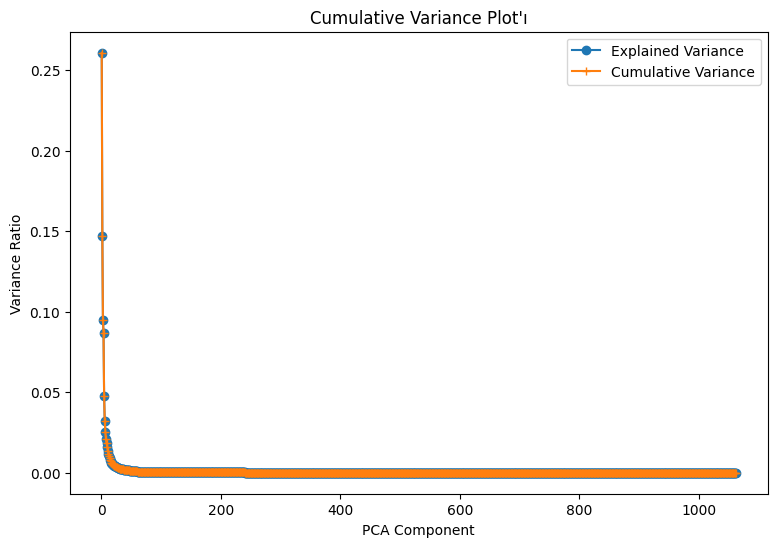

In [8]:
evr = pipe.named_steps["pca"].explained_variance_ratio_
cumvar = np.cumsum(evr)

plt.plot(range(1,len(evr)+1), evr, marker="o", label="Explained Variance")
plt.plot(range(1,len(cumvar)+1), evr, marker="+", label="Cumulative Variance")
plt.xlabel("PCA Component")
plt.ylabel("Variance Ratio")
plt.title("Cumulative Variance Plot'ı")
plt.legend()
plt.show()

In [10]:
n_comp = np.searchsorted(cumvar, 0.70) + 1
print(f"%90 varyansı açıklayan bileşen sayısı: {n_comp}")

%90 varyansı açıklayan bileşen sayısı: 8


In [11]:
pca_final = PCA(n_components=n_comp, random_state=42)
pipe_final = Pipeline(steps=[
    ("preprocess", preprocess),
    ("pca", pca_final)
])

Z = pipe_final.fit_transform(df)

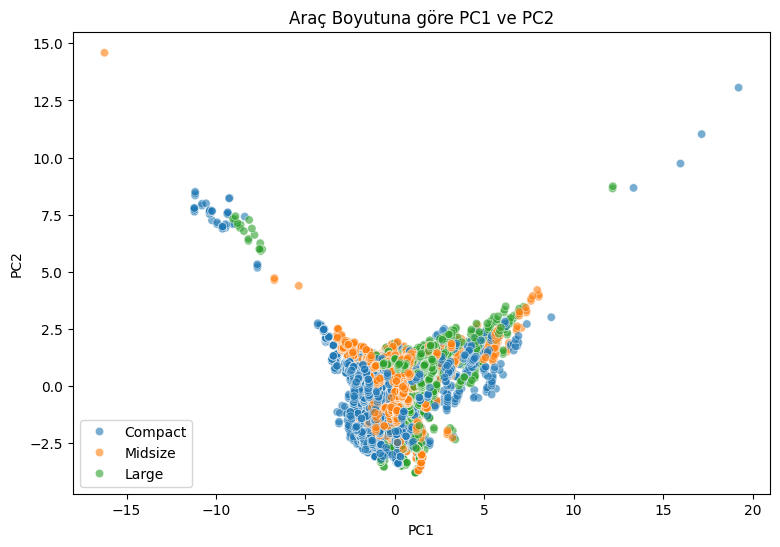

In [13]:
sns.scatterplot(x=Z[:,0],y=Z[:,1], hue=df["Vehicle Size"], alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Araç Boyutuna göre PC1 ve PC2")
plt.legend()
plt.show()

In [16]:
ohe = pipe_final.named_steps["preprocess"].named_transformers_["cat"]
cat_names = ohe.get_feature_names_out(categorical_features)
all_features = numeric_features + cat_names.tolist()

load = pd.DataFrame(
    pipe_final.named_steps["pca"].components_.T,
    index = all_features,
    columns = [f"PC{i+1}" for i in range(n_comp)]
)

print("Load tablosu")
print(load.iloc[:15,:5]) # ilk 15 özellik ve 5 PCA sütunu görünür

Load tablosu
                        PC1       PC2       PC3       PC4       PC5
Year               0.013998  0.609942  0.192790  0.122667  0.566571
Engine HP          0.456651  0.333133 -0.072281  0.003793  0.005305
Engine Cylinders   0.496651  0.015326  0.003817  0.002558 -0.287454
highway MPG       -0.420275  0.365554 -0.264147 -0.021790 -0.177573
Number of Doors   -0.123309  0.221740  0.773921 -0.038649 -0.399801
city mpg          -0.411475  0.343607 -0.268211 -0.004988 -0.294249
MSRP               0.344947  0.352994 -0.251305 -0.147743 -0.422492
Popularity         0.021332  0.009893 -0.046614  0.946679 -0.143292
Make_Acura        -0.001863  0.002017  0.002495 -0.019365  0.008754
Make_Alfa Romeo   -0.000059  0.000173 -0.000684 -0.000344  0.000848
Make_Aston Martin  0.010573  0.004766 -0.011556 -0.008111 -0.005896
Make_Audi          0.001573  0.009330 -0.004996  0.024478  0.002160
Make_BMW           0.005842  0.015329 -0.014093  0.040701  0.004656
Make_Bentley       0.008680  0.0055

/tmp/ipython-input-1269740566.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="PC4", y="Make", data=sample_df, palette="coolwarm")


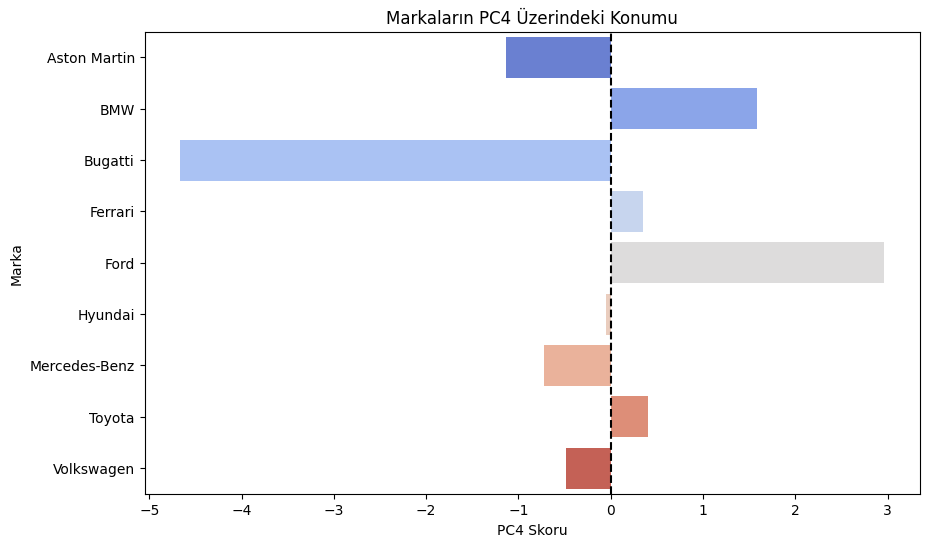

,Make,PC4
0,Aston Martin,-1.131230
1,BMW,1.580630
2,Bugatti,-4.669217
3,Ferrari,0.352926
4,Ford,2.964064
5,Hyundai,-0.050608
6,Mercedes-Benz,-0.723702
7,Toyota,0.408645
8,Volkswagen,-0.484390


In [19]:
df["PC4"] = Z[:,3]

brands= ["Toyota", "Ford","Volkswagen","Hyundai","Ferrari","Bugatti","Aston Martin","BMW","Mercedes-Benz"]

sample_df = df[df["Make"].isin(brands)].groupby("Make")["PC4"].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x="PC4", y="Make", data=sample_df, palette="coolwarm")
plt.axvline(0,color="black",linestyle= "--")
plt.title("Markaların PC4 Üzerindeki Konumu")
plt.xlabel("PC4 Skoru")
plt.ylabel("Marka")
plt.show()

sample_df